# Practica 2 -  Clasificación supervisada en scikit-learn

## Mineria de Datos 2017/2018

* [**Hernan Indibil de La Cruz Calvo**](https://github.com/Mowstyl)
* [**Alejandro Martin Simon Sanchez**](https://github.com/elssbbboy/)

## Indice
1. [Introducción](##Introduccion)
2. [Clasificadores y metodos de evaluacion](##2.SeleccionModelos)
    
    2.1 [Uso del algoritmo Grid Search](###2.1Uso del algoritmo Grid Search)
        2.1.1 [Tratamiento de valores perdidos](####2.1.1 Tratamiento de valores perdidos)
        2.1.2 [Clasificador KNN](####2.1.2 Clasificador KNN)
        2.1.3 [Árboles de decisión](####2.1.3 Árboles de decisión)
        2.1.4 [Métricas](####2.1.4 Métricas)
        2.1.5 [Validación cruzada](####2.1.5 Validación cruzada)
        2.1.6 [Automatización del proceso y análisis de Pima y Wisconsin](####2.1.6 Automatización del proceso y análisis de Pima y Wisconsin)
    2.2 [Comparación de resultados](### 2.2 Comparación de resultados)
        2.2.1 [Pima](####2.2.1 Pima)
        2.2.2 [Wisconsin](####2.2.2 Wisconsin)
    2.3 [Estudio de los algoritmos](###2.3 Estudio de los algoritmos)
        2.3.1 [Pima](####2.3.1 Pima)
            2.3.1.1[KNN](#####2.3.1.1 KNN)
            2.3.1.2[Tree](#####2.3.2.1 Tree)
        2.3.2 [Wisconsin](####2.3.2 Wisconsin)
            2.3.2.1[KNN](#####2.3.2.1 KNN)

## 1. Introduccion
Esta práctica tendrá dos partes:

Primero estudiaremos la API de algunos de los clasificadores más utilizados en `scikit-learn` para conocer los distintos hiperparámetros que los configuran y estudiar los modelos resultantes.

Segundo estudiaremos métodos de selección de modelos, orientados a obtener una configuración óptima de los hiperparámetros para nuestros clasificadores.

In [1]:
# Always load all scipy stack packages
import numpy as np
import pandas as pd
from scipy import stats, integrate
import matplotlib as mpl
import matplotlib.pyplot as plt

import seaborn as sns
sns.set(color_codes=True)

In [2]:
# This code configures matplotlib for proper rendering
%matplotlib inline
mpl.rcParams["figure.figsize"] = "8, 4"
import warnings
warnings.simplefilter("ignore")

In [3]:
# Se establece una semilla predeterminada para que los experimentos sean reproducibles
seed = 6470
np.random.seed(seed)

* **Lo siguiente es cargar los datos que se van a utilizar.**

    Se usa como label la variable categórica.

In [4]:
# Diccionario de nombre: fichero, con los datos de los dataframe a cargar
files = {
    'pima': '../data/pima.csv',
    'wisconsin': '../data/wisconsin.csv'
}

In [5]:
# Se cargan los dataframes
dfs = {name: pd.read_csv(file, dtype={ "label": 'category'}) for name, file in files.items()}

Como vimos en la práctica anterior, las variables de Pima "plas", "pres", "skin", "insu" y "mass" tienen los valores perdidos codificados como 0, ya que es imposible que una persona viva tenga valor 0 en cualquiera de ellas.
Podemos cambiar los 0 por NaN en el dataframe original sin perder información ni sobreajustar de ninguna forma, ya que no usamos información del conjunto de datos.

In [6]:
dfs['pima']['plas'] = dfs['pima']['plas'].replace(0, np.nan)
dfs['pima']['pres'] = dfs['pima']['pres'].replace(0, np.nan)
dfs['pima']['skin'] = dfs['pima']['skin'].replace(0, np.nan)
dfs['pima']['insu'] = dfs['pima']['insu'].replace(0, np.nan)
dfs['pima']['mass'] = dfs['pima']['mass'].replace(0, np.nan)

Para el dataframe Wisconsin la variable Patient ID no aporta nada beneficioso al proceso de clasificación, sólo sobreajuste. No tiene nada que ver con la variable clase. Por ello, procedemos a eliminarla.

In [7]:
dfs['wisconsin'] = dfs['wisconsin'].drop('patientId', 1)

Ahora procedemos a actualizar el diccionario de dataframes para que tenga la siguiente estructura:

* dfs
    * pima
        * train
            * atts
            * label
        * test
            * atts
            * label
    * wisconsin
        * train
            * atts
            * label
        * test
            * atts
            * label

La función utilizada no solo crea la estructura para los dataframes pima y wisconsin, sino para todos los dataframes que haya en el diccionario que se le pase. Realiza el proceso de holdout también para todos los dataframes.

In [8]:
from sklearn.model_selection import train_test_split

def holdout(dframe, seed = None, tsize = 0.2):
    dfAttributes = dframe.drop('label', 1)
    dfLabel = dframe['label']

    df = {}
    df['train'] = {}
    df['test'] = {}

    df['train']['atts'], df['test']['atts'], df['train']['label'], df['test']['label'] = train_test_split(
        dfAttributes,
        dfLabel,
        test_size = tsize,
        random_state = seed,
        stratify = dfLabel)

    return df

dfsh = { name: holdout(dframe, seed, 0.2) for name, dframe in dfs.items() }

## 2. Selección de modelos <a name="##2.SeleccionModelos"></a>

### 2.1 Uso del algoritmo Grid Search

En este apartado se utiliza el algoritmo Grid Search para encontrar la configuración óptima para los distintos estimadores. Dicho algoritmo recibe como parámetros el estimador a configurar y los  a ajustar con una lista de los posibles valores que puedan tomar.
Por ello, para poder utilizarlo debemos primero ver cómo se crean los estimadores y qué variables pueden tener y en qué rango deben ser ajustadas.

#### 2.1.1 Tratamiento de valores perdidos

Sobre los distintos dataframes es posible realizar un tratamiento de los valores perdidos.
Es posible realizarlo mediante un Imputer de scikit, que realizará automáticamente el cambio de los mismos por la media, mediana o moda según cómo se indique la estrategia.

In [9]:
from sklearn.preprocessing import Imputer

In [10]:
# Ejemplo

# El siguiente imputer sustituye los np.nan por la media (Valores por defecto)
# Primero definimos el modelo
imp = Imputer()

# Ahora lo entrenamos
imp = imp.fit(dfsh['pima']['train']['atts'])

# Finalmente lo podemos usar para transformar el dataframe de la siguiente forma
X = imp.transform(dfsh['pima']['train']['atts'])
Y = imp.transform(dfsh['pima']['test']['atts'])

# El resultado es una matriz, por lo que debemos transformarla de nuevo en un dataframe
train_attsFull = pd.DataFrame(X, columns = dfsh['pima']['train']['atts'].columns)
test_attsFull = pd.DataFrame(Y, columns = dfsh['pima']['test']['atts'].columns)

train_attsFull.describe()

,preg,plas,pres,skin,insu,mass,pedi,age
count,614.000000,614.000000,614.000000,614.000000,614.000000,614.000000,614.000000,614.000000
mean,3.884365,122.502463,72.519591,29.392111,156.279874,32.596053,0.480606,33.285016
std,3.396762,30.833718,11.955500,8.914926,87.090249,7.009831,0.331490,11.698435
min,0.000000,44.000000,24.000000,7.000000,15.000000,18.200000,0.078000,21.000000
25%,1.000000,100.000000,64.000000,25.250000,120.500000,27.500000,0.248000,24.000000
50%,3.000000,119.000000,72.519591,29.392111,156.279874,32.400000,0.384000,29.000000
75%,6.000000,142.000000,80.000000,33.000000,156.279874,36.875000,0.639250,40.000000
max,17.000000,198.000000,114.000000,99.000000,846.000000,67.100000,2.329000,81.000000


De esta forma tenemos que por parte del Imputer las variables a configurar son:
* missing_values: variable con el valor con el que se codifican los valores perdidos. Por defecto missing_values = 'NaN', que sustituye los np.nan.
* strategy: variable que indica con qué se reemplazan los valores perdidos. Puede ser: 'mean', 'median' y 'most_frequent'. Por defecto strategy = 'mean'.
* axis: eje en el que se hace la imputación (0 para columnas, 1 para filas). Por defecto axis = 0.

La información ha sido obtenida de la documentación encontrada en [sklearn.preprocessing.Imputer](http://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.Imputer.html#sklearn.preprocessing.Imputer.fit_transform).

Una vez terminado el tratamiento de valores perdidos, podemos proceder a crear los clasificadores. En esta práctica se utilizarán dos métodos de clasificación: KNN y árbol de decisión.

#### 2.1.2 Clasificador KNN

KNN es un clasificador sencillo de entender y configurar, ya que solo tendremos que fijar el parámetro `k` que determina el número de vecinos con los que compararemos.

Se trata de un algoritmo perezoso, es decir, que no realiza fase de aprendizaje previa porque computa los parámetros necesarios para la clasificación durante el propio proceso de clasificación. Aunque esto pueda parecer una ventaja puede llegar a resultar ineficiente para bases de datos con muchas instancias. Además, es muy sensible a cambios en los datos de training.

In [11]:
from sklearn import neighbors

In [12]:
# Ejemplo

# Se prueba el clasificador con un valor de k = 5 vecinos sin pesar por la distancia (Por defecto).
# La distancia usada es la de Minkowski
model = neighbors.KNeighborsClassifier()
# Como es perezoso solo se inicializa su estado.

# A continuacion se aprenden los datos del conjunto de training.
knn = model.fit(train_attsFull, dfsh['pima']['train']['label'])

predictionKNN = knn.predict(test_attsFull)

De esta forma tenemos que por parte del clasificador KNN los hiperparámetros a configurar son:
* n_neighbors: variable con el número de vecinos usados. Por defecto n_neighbors = 5. Es la K de KNN.
* weights: variable que indica cómo pesar los vecinos a la hora de clasificar, pudiendo elegir entre que todos pesen lo mismo ('uniform') o pesar por la inversa de la distancia ('distance'). También es posible pasar por parámetro una función que devuelva el peso recibiendo como argumento un array de distancias. Por defecto weights = 'uniform'.
* metric: métrica de distancia a utilizar. Las posibles métricas pueden encontrarse en [class DistanceMetric](http://scikit-learn.org/stable/modules/generated/sklearn.neighbors.DistanceMetric.html). Por defecto metric = 'minkowski'.
* p: parámetro para la métrica de distancia 'minkowski', donde la distancia entre x e y se calcula como sum(|x - y|^p)^(1/p). Por ejemplo para p = 1 es la distancia de Manhattan y con p = 2 es la Euclídea. Por defecto p = 2.
* metric_params: otros argumentos que pueden ser usados en la función de distancia escogida. Por ejemplo en la distancia de Mahalanobis o en la de WMinkowski.

Hay más variables que sirven para mejorar la eficiencia pero que no afectan al resultado de la clasificación, que afectan por ejemplo al nivel de concurrencia. Por ello, no las trataremos de momento.

La información ha sido obtenida de la documentación encontrada en [sklearn.neighbors.KNeighborsClassifier](http://scikit-learn.org/stable/modules/generated/sklearn.neighbors.KNeighborsClassifier.html#sklearn.neighbors.KNeighborsClassifier).

#### 2.1.3 Árboles de decisión

En la práctica anterior ya se trabajó con árboles de decisión, por lo que ahora nos centraremos más en los hiperparámetros:

In [13]:
from sklearn import tree

In [14]:
# Ejemplo

# Iniciamos el modelo usando la impureza Gini como criterio para las divisiones, sin profundidad máxima.
model = tree.DecisionTreeClassifier(random_state = seed)

# Entrenamos el modelo
classifier = model.fit(train_attsFull, dfsh['pima']['train']['label'])

# Obtenemos la predicción
predictionTree = classifier.predict(test_attsFull)

De esta forma tenemos que por parte del árbol de decisión los hiperparámetros a configurar son:
* criterion: variable con el criterio para hacer las divisiones. Puede ser 'gini' para usar la impureza Gini o 'entropy' para usar la ganancia de información. Por defecto criterion = 'gini'.
* splitter: variable que permite decidir entre buscar el mejor corte con 'best' o el mejor corte aleatorio con 'random'. Por defecto splitter = 'best'.
* max_depth: variable que establece la profundidad máxima del árbol. Reducirla puede ayudar a evitar el sobreajuste. Por defecto max_depth = None.
* min_samples_split: variable que permite determinar el mínimo número de instancias necesarias para dividir un nodo interno. Aumentar el número permite disminuir el sobreajuste. Por defecto min_samples_split = 2.
* min_samples_leaf: variable que permite determinar el mínimo número de casos necesarios para que un nodo sea hoja. Aumentar el número permite disminuir el sobreajuste. Por defecto min_samples_leaf = 1.
* min_weight_fraction_leaf: se usa cuando a la hora de entrenar se han especificado pesos para los distintos casos. De no especificarse todos los casos tendrán el mismo peso. La variable indica la minima fracción de peso del total de pesos necesaria para que un nodo pueda ser hoja. Por defecto min_weight_fraction_leaf = 0. (debe ser float).
* max_features: el número de variables a considerar a la hora de buscar el mejor corte. Se puede especificar un entero, un flotante con el porcentaje, 'auto' o 'sqrt' para tomar la raíz del número total de variables (¿por qué auto hace siempre lo mismo?), 'log2' para tomar el logaritmo en base 2 o None para tomar max_features = numero total de variables. Por defecto max_features = None.
* max_leaf_nodes: máximo número de nodos hoja, donde el árbol se construirá con primero-mejor pesando con la impureza. Por defecto max_leaf_nodes = None.
* min_impurity_decrease: un nodo se divide si al hacerlo se produce una disminución de impureza mayor o igual a éste valor. Aumentar el valor disminuye el sobreajuste. Por defecto min_impurity_decrease = 0.
* class_weight: indica el peso de cada etiqueta posible de la variable clase (también puede usarse en problemas multiclase). Puede pasarse un diccionario etiqueta: peso, una lista de diccionarios, 'balanced' para que pese las etiquetas en función de la inversa de sus frecuencias de aparición o None para que todas tengan el mismo peso. Por defecto class_weight = None.

Hay más hiperparámetros que sirven para mejorar la eficiencia pero que no afectan al resultado de la clasificación, como presort. También tenemos el hiperparámetro random_state, para introducir la semilla. Por ello, no las trataremos de momento.

La información ha sido obtenida de la documentación encontrada en [sklearn.tree.DecisionTreeClassifier](http://scikit-learn.org/stable/modules/generated/sklearn.tree.DecisionTreeClassifier.html)

#### 2.1.4 Métricas

Para evaluar un modelo es necesario utilizar métricas. Aparte de la tasa de aciertos (accuracy) es importante observar otros parámetros como la precisión, recall, f1 score y el área bajo la curva (AUC).
Scikit-learn automatiza el proceso de obtener todas estas métricas mediante el paquete sklearn.metrics. Las métricas calculadas por sklearn son las que aparecen en la documentación [Docs: Evaluación de modelos](http://scikit-learn.org/stable/modules/model_evaluation.html#the-scoring-parameter-defining-model-evaluation-rules)

In [15]:
import sklearn.metrics as metrics

In [16]:
# Ejemplo

# Matriz de confusion
print ('Matriz de confusion - arbol: ')
print (metrics.confusion_matrix(dfsh['pima']['test']['label'], predictionTree))
print ('Matriz de confusion - KNN: ')
print (metrics.confusion_matrix(dfsh['pima']['test']['label'], predictionKNN))

# Tasa de acierto - Accuracy
print ('\nTasa de acierto - arbol: ')
print (metrics.accuracy_score(dfsh['pima']['test']['label'], predictionTree))

print ('Tasa de acierto - KNN: ')
print (metrics.accuracy_score(dfsh['pima']['test']['label'], predictionKNN))

# Recall
print('\nRecall - arbol:')
print(metrics.recall_score(dfsh['pima']['test']['label'], predictionTree, pos_label="tested_positive"))
print('Recall - KNN:')
print(metrics.recall_score(dfsh['pima']['test']['label'], predictionKNN, pos_label="tested_positive"))

# Precision
print('\n Precision - arbol:')
print(metrics.precision_score(dfsh['pima']['test']['label'], predictionTree, pos_label="tested_positive"))
print('Precision - arbol:')
print(metrics.precision_score(dfsh['pima']['test']['label'], predictionKNN, pos_label="tested_positive"))

Matriz de confusion - arbol: 
[[76 24]
 [25 29]]
Matriz de confusion - KNN: 
[[88 12]
 [28 26]]

Tasa de acierto - arbol: 
0.681818181818
Tasa de acierto - KNN: 
0.74025974026

Recall - arbol:
0.537037037037
Recall - KNN:
0.481481481481

 Precision - arbol:
0.547169811321
Precision - arbol:
0.684210526316


#### 2.1.5 Validación cruzada

Tal y como se indica en [sklearn.model_selection.GridSearchCV](http://scikit-learn.org/stable/modules/generated/sklearn.model_selection.GridSearchCV.html), GridSearchCV realiza un proceso de validación cruzada para obtener los mejores parámetros para los estimadores a evaluar.

Para realizar la validación cruzada y obtener métricas para compararlas usamos la siguiente función:

In [17]:
from sklearn.model_selection import cross_val_score

In [18]:
# Ejemplo

model = tree.DecisionTreeClassifier(random_state = seed)

scores = cross_val_score(estimator=model, X=train_attsFull, y=dfsh['pima']['train']['label'], scoring="accuracy", cv=10)

print("Accuracy: %0.2f (+/- %0.2f)" % (scores.mean(), scores.std() * 2))

Accuracy: 0.70 (+/- 0.14)


#### 2.1.6 Automatización del proceso y análisis de Pima y Wisconsin

A continuación agruparemos el Imputer y el clasificador mediante el uso de Pipelines.

In [19]:
from sklearn.pipeline import Pipeline

In [20]:
# Ejemplo

# Primero definimos el estimador. Este pipeline sustituye np.nan por la media y aplica el arbol de decision.
estimator = Pipeline([("imputer", Imputer()),
                      ("tree", tree.DecisionTreeClassifier(random_state = seed))])

# Ahora entrenamos el estimador
cls = estimator.fit(dfsh['pima']['train']['atts'], dfsh['pima']['train']['label'])

# Y podemos proceder a realizar una prediccion
prediction = estimator.predict(dfsh['pima']['test']['atts'])
metrics.accuracy_score(dfsh['pima']['test']['label'], prediction)

0.68181818181818177

Ahora procederemos, una vez decidido cómo se define el estimador a utilizar, a utilizar GridSearchCV para ajustar los hiperparámetros.

De esta forma tenemos dos posibles casos, ambos con una parte común:
* Estimador con Imputer y KNN
* Estimador con Imputer y árbol de decisión

Los hiperparámetros que se deben considerar al usar GridSearchCV son los explicados en los apartados dedicados a Imputer, KNN y DecisionTreeClassifier.

In [21]:
from sklearn.model_selection import GridSearchCV

In [22]:
imputerParams = {
    'imputer__strategy': ['median', 'mean', 'most_frequent']
}

knnParams = {
    'knn__n_neighbors': [i for i in range(3,8)],
    'knn__weights': ['uniform', 'distance'],
    'knn__p': [1, 2]
}

treeParams = {
    'tree__criterion': ['gini', 'entropy'],
    'tree__splitter': ['best', 'random'],
    'tree__max_depth': [None] + [i for i in range(5, 7)],
    'tree__min_samples_split': [i for i in range(2, 5)],
    'tree__max_features': [None, 'log2', 'sqrt'],
    'tree__class_weight': [None, 'balanced'],
    'tree__random_state': [seed]
}

Una vez definidos los parámetros se puede aplicar el GridSearch:

In [23]:
# Ejemplo

# En este ejemplo, usaremos un arbol de decision. Primero definimos el estimador
est = Pipeline([("imputer", Imputer()),
                ("knn", neighbors.KNeighborsClassifier(metric = 'minkowski'))])

# Se crea el objeto
np.random.seed(seed)
clf = GridSearchCV(
    estimator = est,
    param_grid = { **imputerParams, **knnParams }, # Union de ambos diccionarios
    scoring = "accuracy",
    cv = 5,
    n_jobs = -1
)

# Se procede a entrenar
fitted = clf.fit(dfsh['pima']['train']['atts'], dfsh['pima']['train']['label'])

In [24]:
fitted.best_params_

{'imputer__strategy': 'median',
 'knn__n_neighbors': 6,
 'knn__p': 1,
 'knn__weights': 'uniform'}

Una vez conocidos los distintos métodos a usar, procedemos a crear una función que pasado un dataframe como parámetro, usa GridSearchCV para configurar los clasificadores y los devuelve. La función usa por defecto 'accuracy' como scorer, pero puede usar otros como recall o f1 score, especificando pos_label.

In [25]:
from sklearn.metrics import f1_score
from sklearn.metrics import recall_score
from sklearn.metrics import precision_score
from sklearn.metrics import make_scorer

def autoGridClassify(train_atts, train_label, seed = None, scoring = 'accuracy', pos_label = None, cv = 5, iid=True):
    if (scoring in ['recall', 'precision', 'f1'] and pos_label is not None):
        if (scoring == 'recall'):
            score = recall_score
        elif (scoring == 'precision'):
            score = precision_score
        else:
            score = f1_score
        scorer = make_scorer(score, pos_label=pos_label)
    else:
        scorer = scoring
    
    e1 = Pipeline([("imputer", Imputer()),
                   ("knn", neighbors.KNeighborsClassifier())])
    
    e2 = Pipeline([("imputer", Imputer()),
                   ("tree", tree.DecisionTreeClassifier())])
    
    cls = {}
    np.random.seed(seed)
    cls['knn'] = GridSearchCV(
                estimator = e1,
                param_grid = { **imputerParams, **knnParams }, # Union de ambos diccionarios
                scoring = scorer,
                cv = cv,
                n_jobs = -1,
                iid = iid
            )
    
    
    np.random.seed(seed)
    cls['tree'] = GridSearchCV(
                estimator = e2,
                param_grid = { **imputerParams, **treeParams }, # Union de ambos diccionarios
                scoring = scorer,
                cv = cv,
                n_jobs = -1,
                iid = iid
            )
    
    fitted = {}
    fitted['knn'] = cls['knn'].fit(train_atts, train_label)
    fitted['tree'] = cls['tree'].fit(train_atts, train_label)
    
    return cls, fitted

Y finalmente procedemos a realizar el proceso completo de clasificación con Pima y Wisconsin:

In [26]:
# Recordemos que en dfsh ya estan todos los dataframes tras realizar el holdout
cls = {}
fitted = {}
results = {}

for k in dfsh:
    results[k] = {}
    if (k == 'pima'):
        pl = 'tested_positive'
    elif (k == 'wisconsin'):
        pl = 'malignant'
    else:
        pl = None
    
    cls[k], fitted[k] = autoGridClassify(dfsh[k]['train']['atts'], dfsh[k]['train']['label'], seed=seed,
                                        scoring = 'f1', pos_label = pl, cv = 10, iid = False)
    
    for alg, cl in cls[k].items():
        results[k][alg] = cl.predict(dfsh[k]['test']['atts'])

En el diccionario results tenemos los resultados de las predicciones de cada dataframe con cada algoritmo de la siguiente manera:

    results['DataFrame']['Algoritmo']

### 2.2 Comparación de resultados

Una vez obtenidos los clasificadores y hechas las predicciones, podemos a proceder a comparar los resultados obtenidos por cada clasificador en cada base de datos.

In [27]:
# Metodo que pasado test_label y un diccionario con predicciones indizadas
#   por el algoritmo devuelve una tabla con las metricas utilizadas

def metricTable(test_label, predictions, pos_label):
    algL = []
    accuracyL = []
    recallL = []
    precisionL = []
    f1scoreL = []
    aucL = []

    for alg, prediction in predictions.items():
        algL.append(alg)
        accuracyL.append(metrics.accuracy_score(test_label, prediction))
        recallL.append(metrics.recall_score(test_label, prediction, pos_label=pos_label))
        precisionL.append(metrics.precision_score(test_label, prediction, pos_label=pos_label))
        f1scoreL.append(metrics.f1_score(test_label, prediction, pos_label=pos_label))
        aucL.append(metrics.roc_auc_score(y_true=pd.get_dummies(test_label), y_score=pd.get_dummies(prediction)))

    table = [('Algorithm', algL),
             ('Accuracy', accuracyL),
             ('Recall', recallL),
             ('Precision', precisionL),
             ('F1 Score', f1scoreL),
             ('ROC AUC', aucL)
             ]

    return pd.DataFrame.from_items(table)

def cMatrix(matrix, pos_label, neg_label):
    rowL = [pos_label, neg_label]
    tColL = [matrix[1,1], matrix[0,1]]
    fColL = [matrix[1,0], matrix[0,0]]
    table = [('Actual \ Pred', rowL),
             (pos_label, tColL),
             (neg_label, fColL)]
    return pd.DataFrame.from_items(table)

#### 2.2.1 Pima

In [28]:
print("KNN")
c = cMatrix(metrics.confusion_matrix(dfsh['pima']['test']['label'], results['pima']['knn']), 'tested_positive', 'tested_negative')
print(c.to_string(index=False))
print("\nTree")
c = cMatrix(metrics.confusion_matrix(dfsh['pima']['test']['label'], results['pima']['tree']), 'tested_positive', 'tested_negative')
print(c.to_string(index=False))

KNN
Actual \ Pred  tested_positive  tested_negative
tested_positive               26               28
tested_negative               12               88

Tree
Actual \ Pred  tested_positive  tested_negative
tested_positive               35               19
tested_negative               22               78


Observando la matriz de confusión vemos que el árbol aunque acierte más detectando positivos que KNN, lo hace a costa de un aumento de los falsos positivos. Por otro lado, esto trae consigo una reducción en los falsos negativos aunque también en los verdaderos negativos.

In [29]:
metricTable(dfsh['pima']['test']['label'], results['pima'], 'tested_positive')

,Algorithm,Accuracy,Recall,Precision,F1 Score,ROC AUC
0,knn,0.740260,0.481481,0.684211,0.565217,0.680741
1,tree,0.733766,0.648148,0.614035,0.630631,0.714074


Aunque el accuracy y la precisión usando KNN sean ligeramente mayores, en éste problema los falsos negativos pueden traer consigo un coste humano, por lo que se preferiría el árbol de decisión. Éste tiene un mayor recall y F1 score (a pesar de que tenga una precisión un poco menor), además de tener mayor AUC.
Por ello, el modelo preferido sería el creado usando el árbol de decisión.

#### 2.2.2 Wisconsin

In [30]:
print("KNN")
c = cMatrix(metrics.confusion_matrix(dfsh['wisconsin']['test']['label'], results['wisconsin']['knn']), 'malignant', 'benign')
print(c.to_string(index=False))
print("\nTree")
c = cMatrix(metrics.confusion_matrix(dfsh['wisconsin']['test']['label'], results['wisconsin']['tree']), 'malignant', 'benign')
print(c.to_string(index=False))

KNN
Actual \ Pred  malignant  benign
   malignant         47       1
      benign          3      89

Tree
Actual \ Pred  malignant  benign
   malignant         46       2
      benign          6      86


En la matriz de confusión se puede observar que KNN tiene un mayor número de verdaderos positivos y verdaderos negativos que el árbol, lo que trae consigo un menor número de falsos positivos y negativos lo que a priori hace al modelo creado con KNN el mejor para éste problema.

In [31]:
metricTable(dfsh['wisconsin']['test']['label'], results['wisconsin'], 'malignant')

,Algorithm,Accuracy,Recall,Precision,F1 Score,ROC AUC
0,knn,0.971429,0.979167,0.940000,0.959184,0.973279
1,tree,0.942857,0.958333,0.884615,0.920000,0.946558


Para el dataframe Wisconsin, KNN obtiene un mejor resultado en prácticamente todas las métricas consideradas, por lo que el mejor modelo es el generado con KNN.

### 2.3 Estudio de los algoritmos

Ahora procederemos a analizar por separado los hiperparámetros obtenidos al aplicar GridSearchCV, viendo las fronteras de decisión generadas en cada uno de los modelos.

In [32]:
# Print boundaries
def classifierPrintBoundaries(model, train_atts, train_label, test_atts, test_label):

    attsPair = [ (x,y) for x in train_atts.columns for y in train_atts.columns if x != y]
    
    for (att1_name, att2_name) in attsPair:
        
        xx, yy = np.meshgrid(np.arange(min(train_atts[att1_name])-1, max(train_atts[att1_name])+1, 0.05),
                             np.arange(min(train_atts[att2_name])-1, max(train_atts[att2_name])+1, 0.05))

        mesh = pd.DataFrame({ 'x' : xx.ravel(), 'y' : yy.ravel() })
        
        cls = model.fit(train_atts[[att1_name, att2_name]], train_label)

        Z = cls.predict(mesh)
        mesh = mesh.assign( label = pd.Categorical(Z, categories=train_label.cat.categories) )

        colors = ["#4D73AB","#54A86F","#C44D54"]

        mesh = mesh.assign(colors = mesh.label.cat.codes.map(lambda x: colors[x]))
        colorBoundary = list(mesh.label.cat.codes.map(lambda x: colors[x]))
        colorObservations = list(test_label.cat.codes.map(lambda x: colors[x]))

        fig, ax = plt.subplots()
        # Plot using Seaborn
        sns.regplot(x='x', y='y', data=mesh,
                   fit_reg=False, 
                   scatter_kws={'color': colorBoundary})

        sns.regplot(x=att1_name, y=att2_name, data=test_atts,
                   fit_reg=False,
                   scatter_kws={'color': colorObservations,  'lw': 1, 'edgecolor':'#FFFFFF'})



In [33]:
# Print a tree
import pydotplus 
from IPython.display import Image  
def imprimeArbol(model, data, width):
    fnames = data.columns.values[:-1]
    lnames = data['label'].unique()
    dot_data = tree.export_graphviz(model, out_file=None, 
                             feature_names=fnames,  
                             class_names=lnames,  
                             filled=True, rounded=True,  
                             special_characters=True)  
    graph = pydotplus.graph_from_dot_data(dot_data)  
    return Image(graph.create_png(), width=width)  

#### 2.3.1 Pima

##### 2.3.1.1 KNN

In [34]:
# Get the best configuration
fitted['pima']['knn'].best_params_

{'imputer__strategy': 'median',
 'knn__n_neighbors': 7,
 'knn__p': 1,
 'knn__weights': 'uniform'}

In [35]:
best = {}
best['pima'] = {}

# Get the mean score for each cv
means = fitted['pima']['knn'].cv_results_['mean_test_score']
# Get the sd score for each cv
stds = fitted['pima']['knn'].cv_results_['std_test_score']
# Get each specific configuration
conf = fitted['pima']['knn'].cv_results_['params']

# Save the three things togheter
for mean, std, params in zip(means, stds, conf):
    if (params == fitted['pima']['knn'].best_params_):
        best['pima']['knn'] = (mean, std * 2, params)
        
print ("%0.3f (+/-%0.03f) for %r" % best['pima']['knn'])

0.586 (+/-0.223) for {'imputer__strategy': 'median', 'knn__n_neighbors': 7, 'knn__p': 1, 'knn__weights': 'uniform'}


Respecto a KNN aplicado en Pima, tenemos que la configuración cuyo modelo generado tiene (en media al aplicar la validación cruzada) un mayor recall tiene los siguientes hiperparámetros:
* Número de vecinos: 7
* Fórmula distancia: Manhattan
* Peso de los vecinos: Uniforme

Un bajo número de vecinos haría al clasificador muy sensible al ruido y por lo tanto tendría mucha varianza. La frontera de decisión se verá muy afectada por los outliers y no estará muy bien definida (overfitting).
Por otro lado, si la k es muy alta aunque baje la varianza el sesgo aumenta ya que podría no ser capaz de capturar ciertas zonas del espacio al tratarlas como si fueran ruido, generaliza demasiado (underfitting).
El número de vecinos escogido es el que minimiza sesgo y varianza, es decir, con un número menor de vecinos se verá afectado por el ruido a la hora de clasificar y con un mayor número no será capaz de clasificar bien ciertos casos.

Que el peso de los vecinos sea uniforme quiere decir que a la hora de aplicar el algoritmo sólo nos importan los k vecinos más cercanos y no lo cerca que están del caso a clasificar dichos vecinos, no ponderamos por distancia.
La fórmula utilizada para el cálculo de la distancia en éste caso de Manhattan.

#### 2.3.1.2 Tree

In [36]:
# Get the best configuration
fitted['pima']['tree'].best_params_

{'imputer__strategy': 'median',
 'tree__class_weight': 'balanced',
 'tree__criterion': 'entropy',
 'tree__max_depth': 6,
 'tree__max_features': 'log2',
 'tree__min_samples_split': 4,
 'tree__random_state': 6470,
 'tree__splitter': 'best'}

In [37]:
# Get the mean score for each cv
means = fitted['pima']['tree'].cv_results_['mean_test_score']
# Get the sd score for each cv
stds = fitted['pima']['tree'].cv_results_['std_test_score']
# Get each specific configuration
conf = fitted['pima']['tree'].cv_results_['params']

# Save the three things togheter
for mean, std, params in zip(means, stds, conf):
    if (params == fitted['pima']['tree'].best_params_):
        best['pima']['tree'] = (mean, std * 2, params)
        
print ("%0.3f (+/-%0.03f) for %r" % best['pima']['tree'])

0.669 (+/-0.108) for {'imputer__strategy': 'median', 'tree__class_weight': 'balanced', 'tree__criterion': 'entropy', 'tree__max_depth': 6, 'tree__max_features': 'log2', 'tree__min_samples_split': 4, 'tree__random_state': 6470, 'tree__splitter': 'best'}


Respecto a Tree en Pima, tenemos que la configuración cuyo modelo generado tiene (en media al aplicar la validación cruzada) un mayor recall tiene los siguientes hiperparámetros:
* Peso de la clase: balanced
* Criterio: entropy
* Profundidad máxima: 6
* Número máximo de variables predictoras: log2
* Mínimo de muestras para separar: 4
* Separador: best

Dado que el peso dado a la clase es balanceado, de forma que pesa las etiquetas en función de la inversa de sus frecuencias de aparición, por lo que el peso que se le asigna a la clase mayoritaria es menor.

Se toma como criterio de clasificación la entropía, así utilizando la ganancia de información para construir el árbol.

La profundidad máxima que puede tomar el árbol es de 6, no dejando que se expanda en su totalidad. Eso permite evitar sobreajuste, reduciendo así la varianza y haciendo la frontera de decisión más definida. Por otro lado, una profundidad máxima demasiado reducida provocaría underfitting, dicho de otra forma aumentaría el sesgo.

El mínimo de muestras necesarias para separar actua también notablemente sobre la frontera de decisión, un mayor número reduce el sobreajuste y la varianza, pero puede llegar a aumentar el sesgo.

Que como separador se tome 'best' indica que a la hora de realizar los cortes en las variables se buscará el mejor, en lugar de cortar aleatoriamente.

No se toman todas las variables predictoras a la hora de construir el árbol, sino tan solo el logaritmo del número total de variables.

##### Análisis de la estructura de los árboles
A continuación se analizará la estructura de los árboles de la solución óptima y de una subóptima

In [38]:
# Funcion para imprimir el arbol
def imprimeArbol_(treeKey, paramsForThisTree):
    estimatorTree = {}
    optimoCls = {}
    estimatorTree[treeKey] = Pipeline([("imputer", Imputer()),
                          ("tree", tree.DecisionTreeClassifier())])
    estimatorTree[treeKey].set_params(**paramsForThisTree)
    optimoCls[treeKey] = estimatorTree[treeKey].fit(dfsh[treeKey]['train']['atts'], dfsh[treeKey]['train']['label'])
    return imprimeArbol(optimoCls[treeKey].steps[1][1], dfs[treeKey], "1000px")

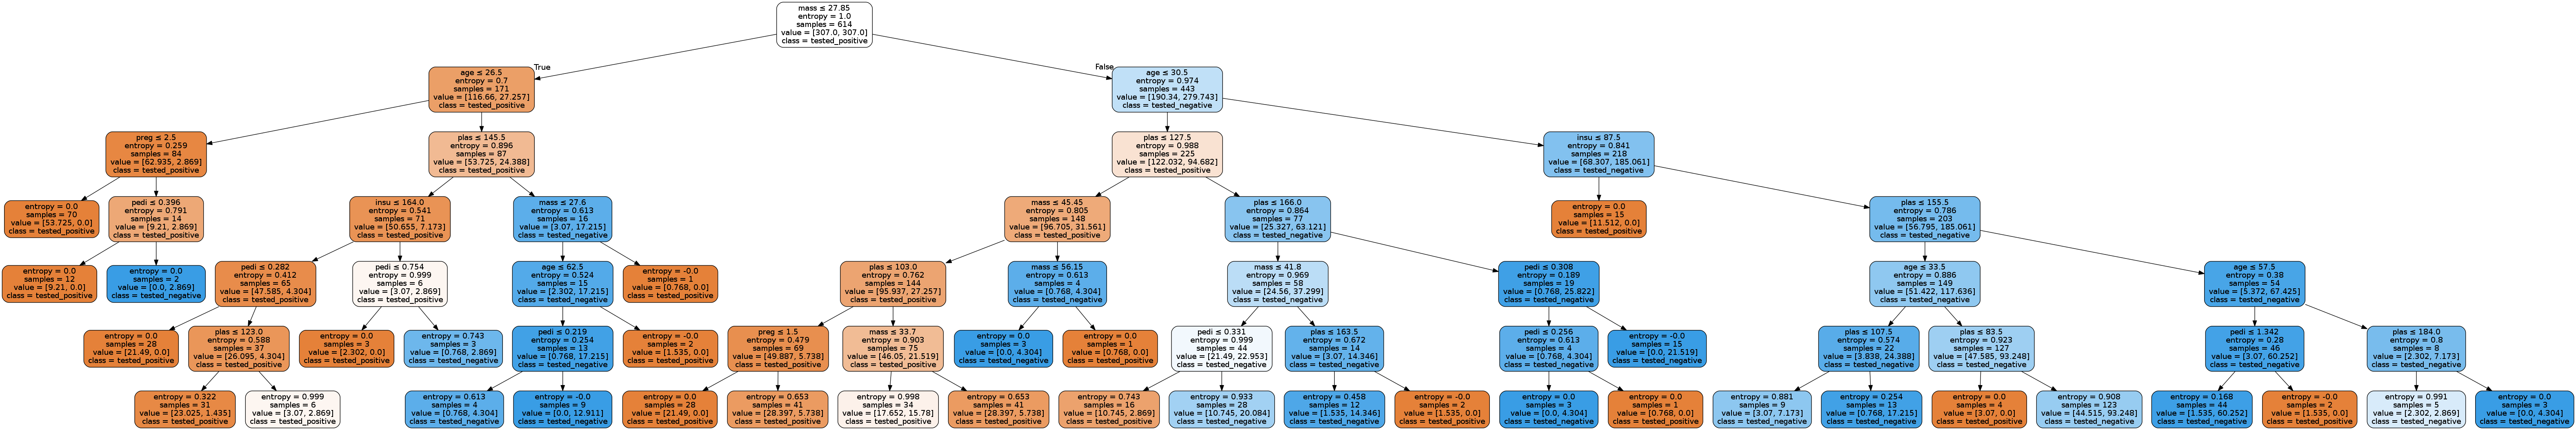

In [39]:
# solucion optima
imprimeArbol_('pima', fitted['pima']['tree'].best_params_)

Como se puede observar en la solución óptima...

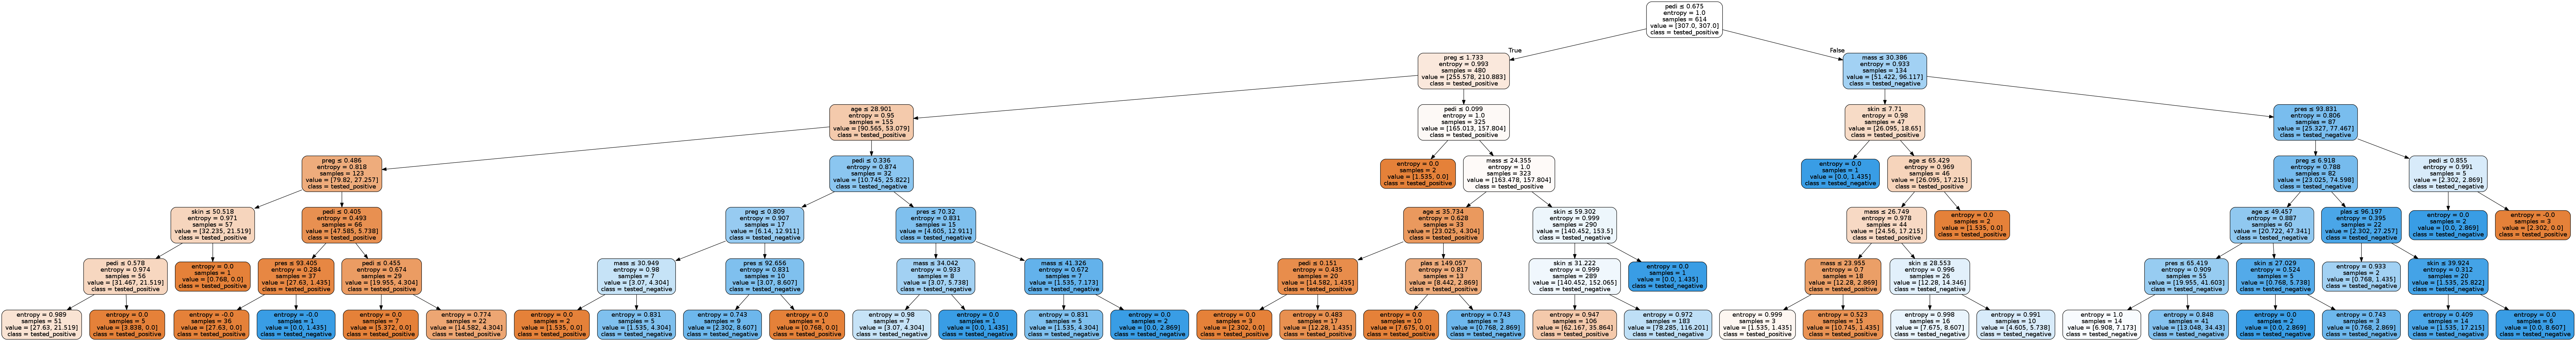

In [68]:
suboptParams = {'imputer__strategy': 'most_frequent', 'tree__criterion': 'entropy', 'tree__splitter': 'random',
                'tree__max_depth': 6, 'tree__min_samples_split': 4, 'tree__max_features': 'sqrt', 
                'tree__class_weight': 'balanced', 'tree__random_state': 6470}
imprimeArbol_('pima',suboptParams)

#### 2.3.2 Wisconsin

##### 2.3.2.1 KNN

In [40]:
# Get the best configuration
fitted['wisconsin']['knn'].best_params_

{'imputer__strategy': 'median',
 'knn__n_neighbors': 7,
 'knn__p': 2,
 'knn__weights': 'uniform'}

In [41]:
best['wisconsin'] = {}

# Get the mean score for each cv
means = fitted['wisconsin']['knn'].cv_results_['mean_test_score']
# Get the sd score for each cv
stds = fitted['wisconsin']['knn'].cv_results_['std_test_score']
# Get each specific configuration
conf = fitted['wisconsin']['knn'].cv_results_['params']

# Save the three things togheter
for mean, std, params in zip(means, stds, conf):
    if (params == fitted['wisconsin']['knn'].best_params_):
        best['wisconsin']['knn'] = (mean, std * 2, params)
        
print ("%0.3f (+/-%0.03f) for %r" % best['wisconsin']['knn'])

0.956 (+/-0.040) for {'imputer__strategy': 'median', 'knn__n_neighbors': 7, 'knn__p': 2, 'knn__weights': 'uniform'}


Respecto a Wisconsin, tenemos que la configuración cuyo modelo generado tiene (en media al aplicar la validación cruzada) un mayor recall tiene los siguientes hiperparámetros:
* Número de vecinos: 7
* Fórmula distancia: Euclídea
* Peso de los vecinos: Uniforme

De nuevo usar 7 como número de vecinos tiene un buen equilibrio entre sesgo y varianza igual que en Pima.
La única diferencia respecto a lo obtenido en Pima es que utilizamos la distancia Euclídea para calcular la distancia, lo cual no tiene un efecto sobre la frontera de decisión tan grande como el número de vecinos.
También viendo el recall obtenido podemos deducir que KNN funciona mejor en Wisconsin que en Pima.
Un apunte importante sobre KNN es que no estamos normalizando las variables predictoras, por lo que las variables que se muevan en un rango más amplio tendrán mucho más peso que las que no lo hacen.
Posiblemente éste hecho esté provocando que Wisconsin, donde las variables tienen un rango más reducido como se vió en el análisis exploratorio, obtenga mejores resultados al usarse KNN que en Pima, donde ciertas variables tienen un rango tan grande que hace que el resto sean casi despreciables.

##### 2.3.2.2 Tree

In [42]:
# Get the best configuration
fitted['wisconsin']['tree'].best_params_

{'imputer__strategy': 'mean',
 'tree__class_weight': 'balanced',
 'tree__criterion': 'gini',
 'tree__max_depth': 5,
 'tree__max_features': None,
 'tree__min_samples_split': 4,
 'tree__random_state': 6470,
 'tree__splitter': 'random'}

In [43]:
# Get the mean score for each cv
means = fitted['wisconsin']['tree'].cv_results_['mean_test_score']
# Get the sd score for each cv
stds = fitted['wisconsin']['tree'].cv_results_['std_test_score']
# Get each specific configuration
conf = fitted['wisconsin']['tree'].cv_results_['params']

# Save the three things togheter
for mean, std, params in zip(means, stds, conf):
    if (params == fitted['wisconsin']['tree'].best_params_):
        best['wisconsin']['tree'] = (mean, std * 2, params)
        
print ("%0.3f (+/-%0.03f) for %r" % best['wisconsin']['tree'])

0.941 (+/-0.068) for {'imputer__strategy': 'mean', 'tree__class_weight': 'balanced', 'tree__criterion': 'gini', 'tree__max_depth': 5, 'tree__max_features': None, 'tree__min_samples_split': 4, 'tree__random_state': 6470, 'tree__splitter': 'random'}


Respecto a Tree en Pima, tenemos que la configuración cuyo modelo generado tiene (en media al aplicar la validación cruzada) un mayor recall tiene los siguientes hiperparámetros:
* Peso de la clase: balanced
* Criterio: gini
* Profundidad máxima: 5
* Número máximo de variables predictoras: None
* Mínimo de muestras para separar: 4
* Separador: random

Dado que el peso dado a la clase es balanceado, de forma que pesa las etiquetas en función de la inversa de sus frecuencias de aparición, por lo que el peso que se le asigna a la clase mayoritaria es menor.

Se toma como criterio de clasificación gini, así utilizando la impureza para construir el árbol.

La profundidad máxima que puede tomar el árbol es de 5, no dejando que se expanda en su totalidad. Eso permite evitar sobreajuste, reduciendo así la varianza y haciendo la frontera de decisión más definida. Por otro lado, una profundidad máxima demasiado reducida provocaría underfitting, dicho de otra forma aumentaría el sesgo.

El mínimo de muestras necesarias para separar actua también notablemente sobre la frontera de decisión, un mayor número reduce el sobreajuste y la varianza, pero puede llegar a aumentar el sesgo.

Que como separador se tome 'random' indica que a la hora de realizar los cortes se realizarán aleatoriamente.

Se toman todas las variables predictoras a la hora de construir el árbol.

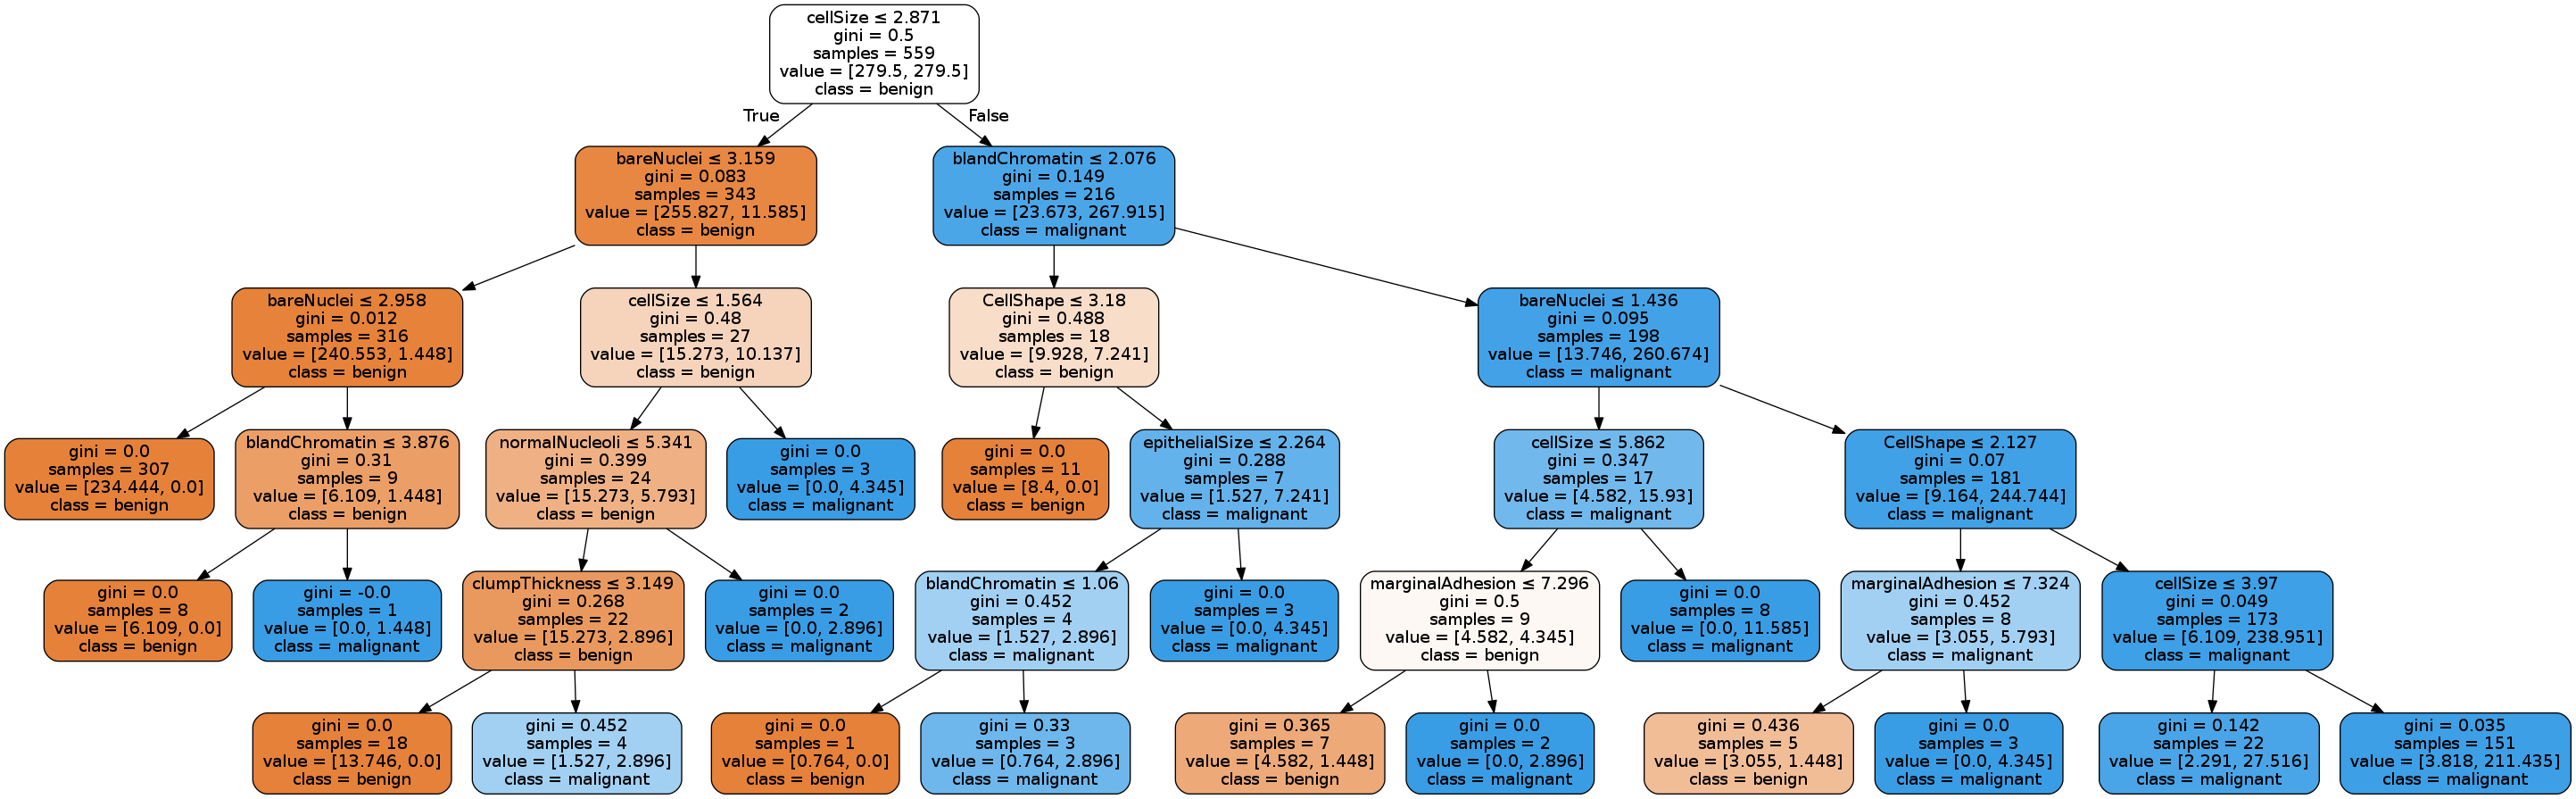

In [44]:
imprimeArbol_('wisconsin', fitted['wisconsin']['tree'].best_params_)

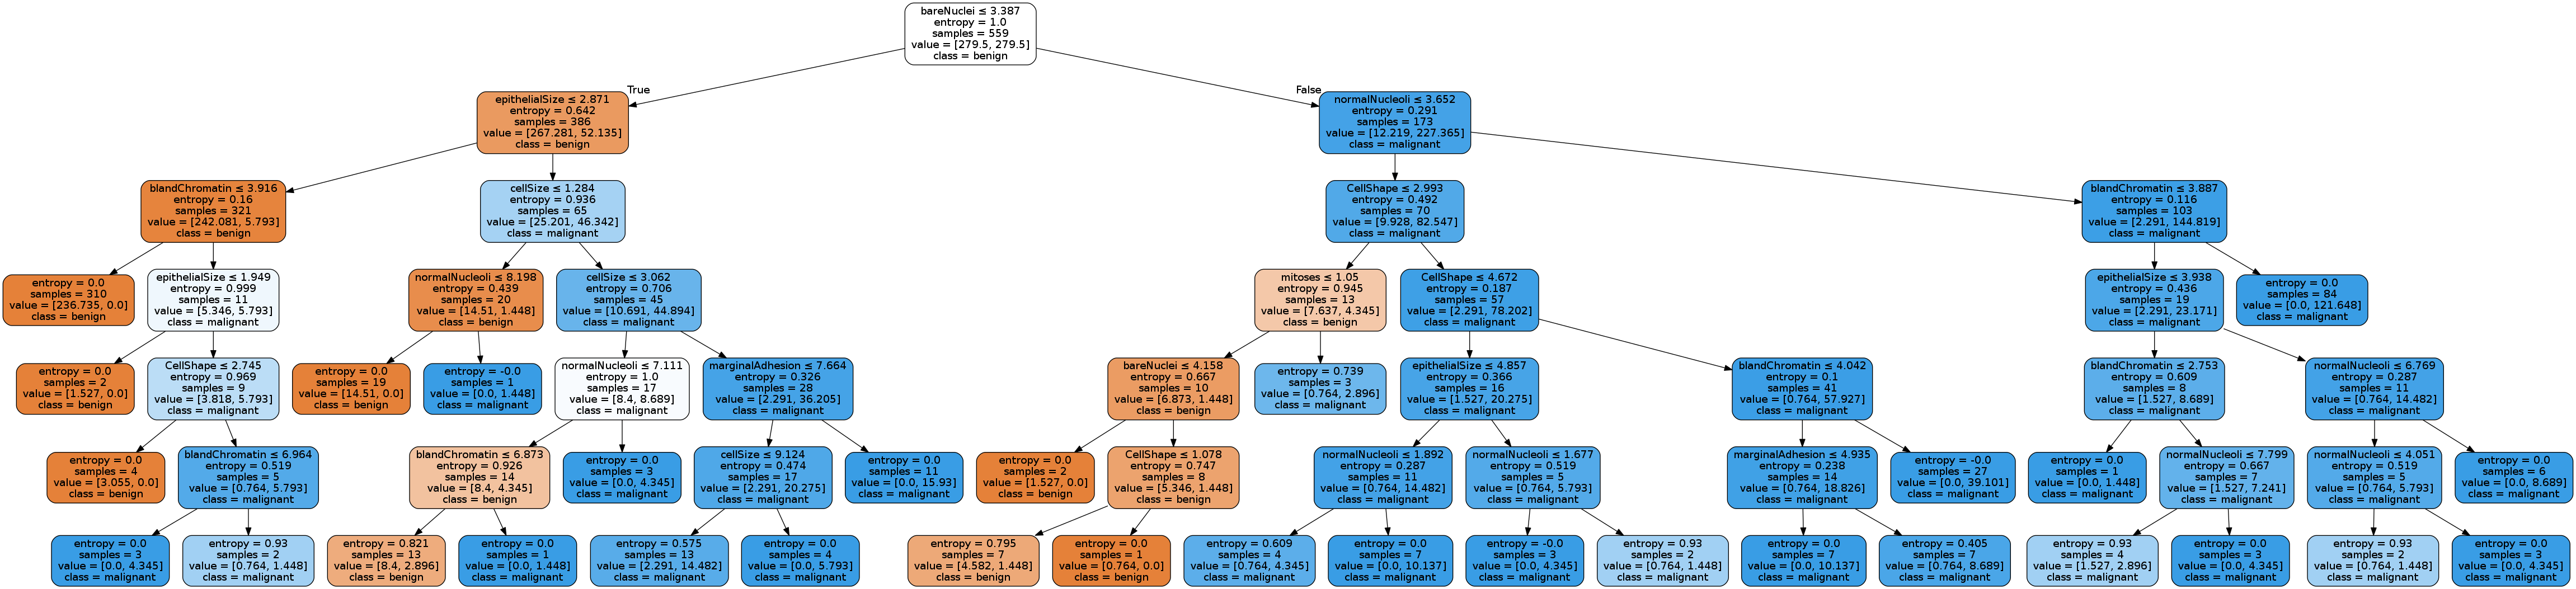

In [69]:
imprimeArbol_('wisconsin',suboptParams)

## 3. Implementación GridSearchCV

In [45]:
{**imputerParams, **knnParams}

{'imputer__strategy': ['median', 'mean', 'most_frequent'],
 'knn__n_neighbors': [3, 4, 5, 6, 7],
 'knn__p': [1, 2],
 'knn__weights': ['uniform', 'distance']}

In [46]:
{**imputerParams, **treeParams}

{'imputer__strategy': ['median', 'mean', 'most_frequent'],
 'tree__class_weight': [None, 'balanced'],
 'tree__criterion': ['gini', 'entropy'],
 'tree__max_depth': [None, 5, 6],
 'tree__max_features': [None, 'log2', 'sqrt'],
 'tree__min_samples_split': [2, 3, 4],
 'tree__random_state': [6470],
 'tree__splitter': ['best', 'random']}

In [47]:
import itertools
from sklearn.model_selection import cross_validate

class GridSearchCVHomeModel:
    def __init__(self, scoring, estimator, param_grid, n_jobs, fit_params, cv, verbose, pre_dispatch):
        self.scoring = scoring
        self.estimator = estimator
        self.param_grid = param_grid
        self.n_jobs = n_jobs
        self.fit_params = fit_params
        self.cv = cv
        self.verbose = verbose
        self.pre_dispatch = pre_dispatch
    
    def fit(self, train_atts, train_label, seed=None): # Africana o europea?
        if type(self.param_grid) is dict:
            self.param_grid = [self.param_grid]

        self.best_score_ = 0
        self.cv_results_ = {}
        self.cv_results_['mean_train_score'] = np.array([])
        self.cv_results_['mean_test_score'] = np.array([])
        self.cv_results_['std_train_score'] = np.array([])
        self.cv_results_['std_test_score'] = np.array([])
        self.cv_results_['mean_fit_time'] = np.array([])
        self.cv_results_['std_fit_time'] = np.array([])
        self.cv_results_['mean_score_time'] = np.array([])
        self.cv_results_['std_score_time'] = np.array([])
        self.cv_results_['params'] = np.array([])
        self.cv_results_['rank_test_score'] = np.array([])
        for i in range(0, self.cv):
            self.cv_results_['split'+str(i)+'_train_score'] = np.array([])
            self.cv_results_['split'+str(i)+'_test_score'] = np.array([])

        for pg in self.param_grid:
            params = {}
            for args in itertools.product(*pg.values()):
                for i in range(0, len(args)):
                    params[list(pg.keys())[i]] = args[i]
                self.estimator.set_params(**params)
                np.random.seed(seed)
                score = cross_validate(self.estimator, train_atts, train_label, scoring=self.scoring, cv=self.cv,
                                        n_jobs=self.n_jobs, fit_params=self.fit_params, verbose=self.verbose,
                                        pre_dispatch=self.pre_dispatch, return_train_score=True)
                
                self.cv_results_['params'] = np.append(self.cv_results_['params'], params)
                self.cv_results_['mean_train_score'] = np.append(self.cv_results_['mean_train_score'], score['train_score'].mean())
                self.cv_results_['mean_test_score'] = np.append(self.cv_results_['mean_test_score'], score['test_score'].mean())
                self.cv_results_['std_train_score'] = np.append(self.cv_results_['std_train_score'], score['train_score'].std())
                self.cv_results_['std_test_score'] = np.append(self.cv_results_['std_test_score'], score['test_score'].std())
                self.cv_results_['mean_fit_time'] = np.append(self.cv_results_['mean_fit_time'], score['fit_time'].mean())
                self.cv_results_['std_fit_time'] = np.append(self.cv_results_['std_fit_time'], score['fit_time'].std())
                self.cv_results_['mean_score_time'] = np.append(self.cv_results_['mean_score_time'], score['score_time'].mean())
                self.cv_results_['std_score_time'] = np.append(self.cv_results_['std_score_time'], score['score_time'].std())
                
                for i in range(0, self.cv):
                    self.cv_results_['split'+str(i)+'_train_score'] = np.append(self.cv_results_['split'+str(i)+'_train_score'], score['train_score'][i])
                    self.cv_results_['split'+str(i)+'_test_score'] = np.append(self.cv_results_['split'+str(i)+'_test_score'], score['test_score'][i])
                
        self.cv_results_['rank_test_score'] = np.array([i[0]+1 for i in sorted(
            enumerate(self.cv_results_['mean_test_score']), key=lambda x:x[1])])
        
        self.best_index_ = np.where(self.cv_results_['rank_test_score']==1)[0][0]
        self.best_score_ = self.cv_results_['mean_test_score'][self.best_index_]
        self.best_params_ = self.cv_results_['params'][self.best_index_]
        self.secbest_index_ = np.where(self.cv_results_['rank_test_score']==10)[0][0]
        self.secbest_score_ = self.cv_results_['mean_test_score'][self.secbest_index_]
        self.secbest_params_ = self.cv_results_['params'][self.secbest_index_]

        self.estimator.set_params(**self.best_params_)
        self.estimator.fit(train_atts, train_label)
        self.best_estimator_ = self.estimator
        
    def predict(self, test_atts):
        return self.best_estimator_.predict(test_atts)

def GridSearchCVHome(estimator, param_grid, scoring=None, cv=None,
                    fit_params=None, n_jobs=1, verbose=0, pre_dispatch='2*n_jobs'):
    return GridSearchCVHomeModel(scoring, estimator, param_grid, n_jobs, fit_params, cv, verbose, pre_dispatch)

est = {}
est['knn'] = Pipeline([("imputer", Imputer()),
                   ("knn", neighbors.KNeighborsClassifier(n_jobs=-1))])

est['tree'] = Pipeline([("imputer", Imputer()),
                          ("tree", tree.DecisionTreeClassifier())])

sc = make_scorer(recall_score, pos_label='tested_positive')
clas = {}
clas['knn'] = GridSearchCVHome(est['knn'], {**imputerParams, **knnParams}, cv=2, n_jobs=-1, scoring=sc)
clas['tree'] = GridSearchCVHome(est['tree'], {**imputerParams, **treeParams}, cv=2, n_jobs=-1, scoring=sc)


clas['knn'].fit(dfsh['pima']['train']['atts'], dfsh['pima']['train']['label'], seed)
clas['tree'].fit(dfsh['pima']['train']['atts'], dfsh['pima']['train']['label'], seed)

In [64]:
print('knn: \n'+str(clas['knn'].best_params_)+'\n\n'+'tree: \n'+str(clas['tree'].secbest_params_))

knn: 
{'imputer__strategy': 'most_frequent', 'knn__n_neighbors': 7, 'knn__weights': 'distance', 'knn__p': 2}

tree: 
{'imputer__strategy': 'most_frequent', 'tree__criterion': 'entropy', 'tree__splitter': 'random', 'tree__max_depth': 6, 'tree__min_samples_split': 4, 'tree__max_features': 'sqrt', 'tree__class_weight': 'balanced', 'tree__random_state': 6470}


In [49]:
clas['knn'].cv_results_.keys()

dict_keys(['mean_train_score', 'mean_test_score', 'std_train_score', 'std_test_score', 'mean_fit_time', 'std_fit_time', 'mean_score_time', 'std_score_time', 'params', 'rank_test_score', 'split0_train_score', 'split0_test_score', 'split1_train_score', 'split1_test_score', 'split2_train_score', 'split2_test_score', 'split3_train_score', 'split3_test_score', 'split4_train_score', 'split4_test_score'])

In [50]:
clas['tree'].cv_results_.keys()

dict_keys(['mean_train_score', 'mean_test_score', 'std_train_score', 'std_test_score', 'mean_fit_time', 'std_fit_time', 'mean_score_time', 'std_score_time', 'params', 'rank_test_score', 'split0_train_score', 'split0_test_score', 'split1_train_score', 'split1_test_score', 'split2_train_score', 'split2_test_score', 'split3_train_score', 'split3_test_score', 'split4_train_score', 'split4_test_score'])

In [51]:
metricTable(dfsh['pima']['test']['label'], {'GSCV_HOME-KNN': clas['knn'].predict(dfsh['pima']['test']['atts']),
                                           'GSCV_SKL-KNN': cls['pima']['knn'].predict(dfsh['pima']['test']['atts']),
                                           'GSCV_HOME-Tree': clas['tree'].predict(dfsh['pima']['test']['atts']),
                                            'GSCV_SKL-Tree': cls['pima']['tree'].predict(dfsh['pima']['test']['atts'])}, 'tested_positive')

,Algorithm,Accuracy,Recall,Precision,F1 Score,ROC AUC
0,GSCV_HOME-KNN,0.746753,0.481481,0.702703,0.571429,0.685741
1,GSCV_SKL-KNN,0.740260,0.481481,0.684211,0.565217,0.680741
2,GSCV_HOME-Tree,0.649351,0.703704,0.500000,0.584615,0.661852
3,GSCV_SKL-Tree,0.733766,0.648148,0.614035,0.630631,0.714074


In [52]:
cls['pima']['knn'].cv_results_['mean_test_score']

array([ 0.55371614,  0.55034796,  0.53808367,  0.53021704,  0.51174098,
        0.55579032,  0.52402267,  0.53092709,  0.58201852,  0.56903229,
        0.57064279,  0.56079718,  0.52227205,  0.57107881,  0.54132167,
        0.55474244,  0.58584321,  0.57798342,  0.57602363,  0.56981431,
        0.51661937,  0.51313505,  0.52899846,  0.51917353,  0.47972372,
        0.53787246,  0.49633963,  0.52223489,  0.56470458,  0.55877389,
        0.53548244,  0.5288551 ,  0.53481964,  0.57974242,  0.53699419,
        0.55358634,  0.56448254,  0.56210414,  0.56741045,  0.56651262,
        0.55463358,  0.55463358,  0.55934272,  0.55070132,  0.52734366,
        0.56152563,  0.49254896,  0.54697231,  0.57812362,  0.57101614,
        0.55933225,  0.54637614,  0.50243035,  0.57167123,  0.51702214,
        0.54804622,  0.57526297,  0.576953  ,  0.56819199,  0.56830632])

In [70]:
cls['pima']['tree'].cv_results_['mean_test_score']

array([ 0.56876081,  0.63104214,  0.5677107 ,  0.52260948,  0.56127142,
        0.55004471,  0.56311064,  0.52380034,  0.57823378,  0.45911927,
        0.57086491,  0.49428634,  0.56455894,  0.5197734 ,  0.54257984,
        0.48874055,  0.60931534,  0.54002573,  0.56975223,  0.51668646,
        0.56975223,  0.52591106,  0.56397528,  0.54538389,  0.61879483,
        0.38019026,  0.61879483,  0.39229981,  0.59950731,  0.39224224,
        0.52002202,  0.42203547,  0.52102081,  0.37592572,  0.55095215,
        0.40816022,  0.55077803,  0.54252788,  0.55199016,  0.58786658,
        0.55294254,  0.56114407,  0.557529  ,  0.41263671,  0.57600106,
        0.38718164,  0.6169288 ,  0.38107809,  0.55135342,  0.47358347,
        0.54554747,  0.47319291,  0.54945194,  0.45615384,  0.56567843,
        0.58605956,  0.56606293,  0.56397871,  0.55439818,  0.52232992,
        0.56631299,  0.52772095,  0.54472868,  0.52557956,  0.6003876 ,
        0.48004938,  0.59487948,  0.50928416,  0.58569944,  0.48

In [56]:
# Get the mean score for each cv
means = fitted['pima']['knn'].cv_results_['mean_test_score']
# Get the sd score for each cv
stds = fitted['pima']['knn'].cv_results_['std_test_score']
# Get each specific configuration
conf = fitted['pima']['knn'].cv_results_['params']

# Save the three things togheter
print('knn:\n')
for mean, std, params in zip(means, stds, conf):
    if (params == fitted['pima']['knn'].best_params_ or params == clas['knn'].best_params_):
        print ("%0.3f (+/-%0.03f) for %r" % (mean, std * 2, params))
        
# Get the mean score for each cv
means = fitted['pima']['tree'].cv_results_['mean_test_score']
# Get the sd score for each cv
stds = fitted['pima']['tree'].cv_results_['std_test_score']
# Get each specific configuration
conf = fitted['pima']['tree'].cv_results_['params']

print('tree:\n')
for mean, std, params in zip(means, stds, conf):
    if (params == fitted['pima']['tree'].best_params_ or params == clas['tree'].best_params_):
        print ("%0.3f (+/-%0.03f) for %r" % (mean, std * 2, params))

knn:

0.586 (+/-0.223) for {'imputer__strategy': 'median', 'knn__n_neighbors': 7, 'knn__p': 1, 'knn__weights': 'uniform'}
0.568 (+/-0.136) for {'imputer__strategy': 'most_frequent', 'knn__n_neighbors': 7, 'knn__p': 2, 'knn__weights': 'distance'}
tree:

0.669 (+/-0.108) for {'imputer__strategy': 'median', 'tree__class_weight': 'balanced', 'tree__criterion': 'entropy', 'tree__max_depth': 6, 'tree__max_features': 'log2', 'tree__min_samples_split': 4, 'tree__random_state': 6470, 'tree__splitter': 'best'}
0.564 (+/-0.100) for {'imputer__strategy': 'most_frequent', 'tree__class_weight': 'balanced', 'tree__criterion': 'entropy', 'tree__max_depth': 6, 'tree__max_features': 'sqrt', 'tree__min_samples_split': 4, 'tree__random_state': 6470, 'tree__splitter': 'random'}


In [71]:
fitted['pima']['knn'].best_score_

0.58584320590128025

In [72]:
fitted['pima']['tree'].best_score_

0.66890377943386414

In [ ]:
temp = Pipeline([("imputer", Imputer()),
                   ("knn", neighbors.KNeighborsClassifier(n_jobs=-1))])

score = cross_validate(temp, dfsh['pima']['train']['atts'], dfsh['pima']['train']['label'],
                       scoring='accuracy', cv=2, n_jobs=-1, return_train_score=True)

In [ ]:
score['fit_time']